<a href="https://colab.research.google.com/github/jopachecoc/AD_1_preguntasmart/blob/main/final_exploratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratorio, preparacion y ML.

Problema: se desea conocer en que es mejor invertir, en el SPY o en un CDT a 4 años?

Pregunta smart: Que es mas rentable En un plazo de 4 años, invertir 20 millones de pesos colombianos en el SPY o en un CDT?, si tenemos en cuenta que la taza del CDT es de 9% efectivo anual.

Importancia de la columna:
Tomamos la informacion de un etf (SPY) de la siguiente URL: https://finance.yahoo.com/quote/SPY/history/?period1=728317800&period2=1723227557 La columna a analizar es el comportamiento historico del ETF SPY (close) que esta basado en el SYP500 el cual es un conjunto de acciones de las mejores 500 empresas de EEUU. necesitamos saber el comportamiento de cierre del ETF diario para poder deducir que es mejor a largo plazo invertir en este o colocar el dinero en un CDT a un plazo de 4 años.

In [1]:
!pip install pmdarima
!pip install dfply

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 14.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from dfply import *
import pmdarima as pm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
file_path = "https://raw.githubusercontent.com/jopachecoc/AD_1_preguntasmart/main/SPY.csv"
df = pd.read_csv(file_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7934,2024-08-05,511.640015,523.580017,510.269989,517.380005,517.380005,146267400
7935,2024-08-06,519.219971,529.750000,517.869995,522.150024,522.150024,84826300
7936,2024-08-07,528.469971,531.590027,518.049988,518.659973,518.659973,70698300
7937,2024-08-08,523.909973,531.289978,521.840027,530.650024,530.650024,62200000
7938,2024-08-09,529.809998,534.510010,528.559998,532.010010,532.010010,27476453


In [3]:
df.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [4]:
print(df['Close'].describe())

count    7939.000000
mean      177.147822
std       115.959374
min        43.406250
25%       106.325001
50%       133.149994
75%       216.360001
max       564.859985
Name: Close, dtype: float64


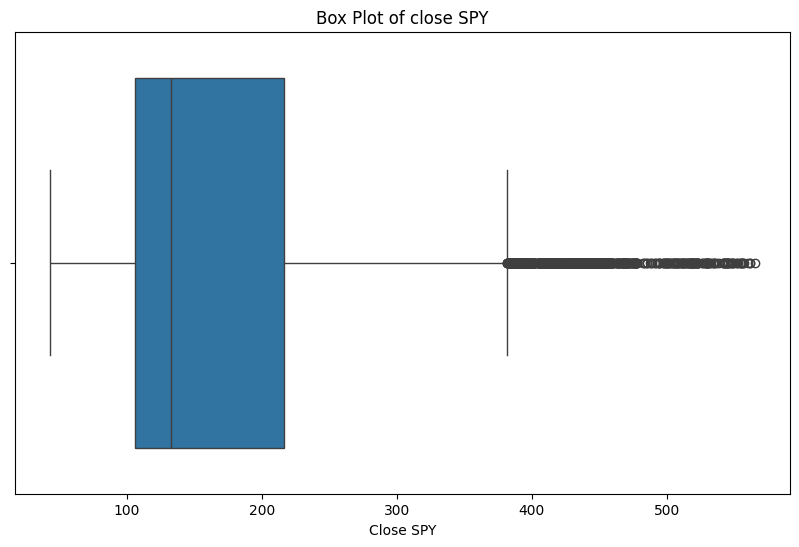

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Close'])
plt.title('Box Plot of close SPY')
plt.xlabel('Close SPY')
plt.show()

# esto me dice que tiene una tendencia exponencial ya que tiene atipicos hacia adelante osea de seguro crece
# mas rapido que un ajuste lineal, para esto podemos calcular el ln y aplicarlo en la variable y
# comparar resultados sobre su comportamiento.


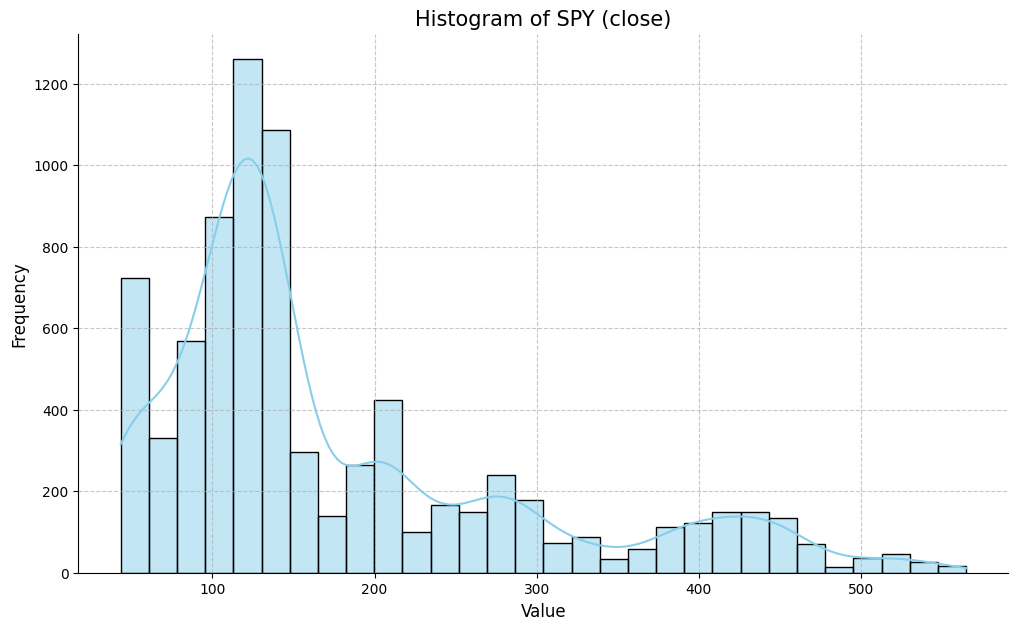

In [6]:
plt.figure(figsize=(12, 7))
sns.histplot(df['Close'], bins=30, kde=True, color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of SPY (close)', fontsize=15)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Customizing the style
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()

# Display the plot
plt.show()

#ser muy habil para poder tomar los valores altos de la serie

In [7]:
#vamos a sacar los años
#df.head()
df['Date'] = pd.to_datetime(df['Date'])
# Extraer el año
df['año'] = df['Date'].dt.year


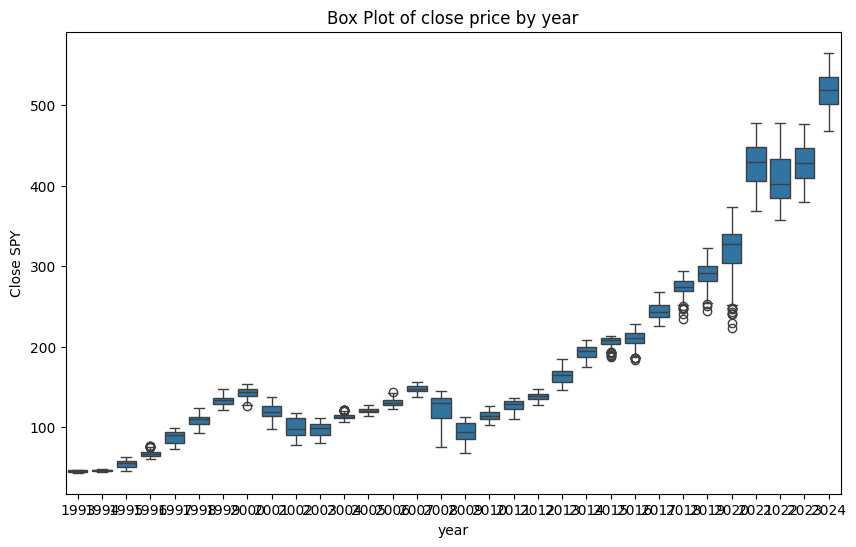

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='año', y='Close', data=df)

# Add titles and labels
plt.title('Box Plot of close price by year')
plt.xlabel('year')
plt.ylabel('Close SPY')

# Show the plot
plt.show()
# Acá encontramos algo interesante y es:
# la variabilidad del precio de cierre se me incrementa en los ultimos años por ende
# los pronosticos seguramente van a tener bandas de confianza amplias esto tambien nos indica que para hacer una inversion
# en SPY se convierte mas riesgosa o mas que riesgosa cuidadosa con escoger el precio de salida o vendida de las acciones


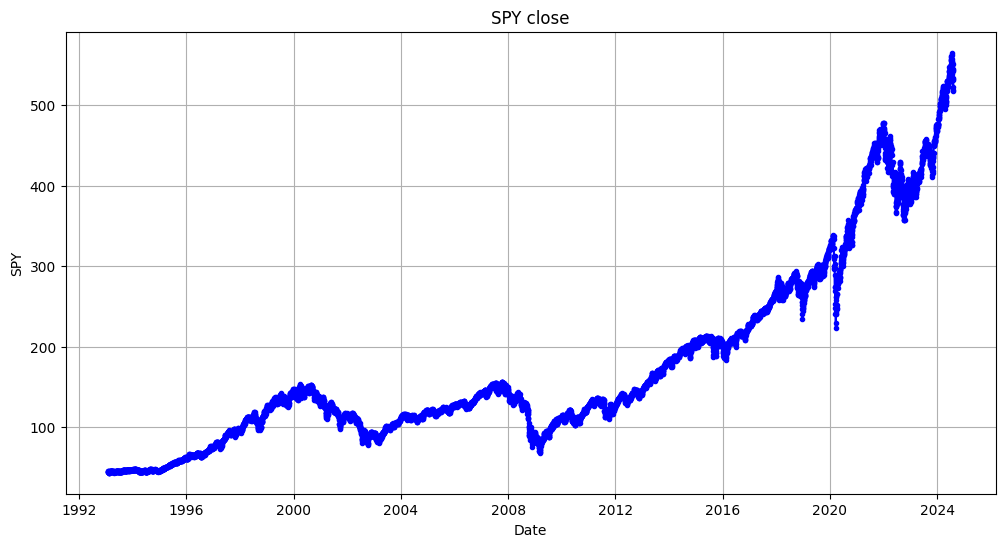

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.Date, df['Close'], marker='.', linestyle='-', color='b')

# Add titles and labels
plt.title('SPY close')
plt.xlabel('Date')
plt.ylabel('SPY')
plt.grid(True)

# Show the plot
plt.show()

In [4]:
# primero vamos a testear un auto arima a ver que resultados nos da  de la serie luego lo haremos mas
# formalmente para validar y contrastar los modelos seleccionados
dff = pd.DataFrame(df[['Date','Close']])
dff['Date'] = pd.to_datetime(dff['Date'])
dff = dff.reset_index(drop=True)
all_day = pd.date_range(start=dff['Date'].min(), end=dff['Date'].max(), freq='D')
columns = ['Date']
all_days = pd.DataFrame(all_day, columns=columns)
all_days = all_days.reset_index(drop=True)
result = (all_days >> left_join(dff, by='Date'))
# Rellenar los fines de semana con el último valor disponible
result['Close'] = result['Close'].ffill()
series = result.set_index('Date')['Close']
series

,Close
Date,
1993-01-29,43.937500
1993-01-30,43.937500
1993-01-31,43.937500
1993-02-01,44.250000
1993-02-02,44.343750
...,...
2024-08-05,517.380005
2024-08-06,522.150024
2024-08-07,518.659973


In [5]:
series1 = result.set_index('Date')['Close']
# Número de periodos en el conjunto de prueba 9200 para que quede un 85-15
train1 = series1[:-int(series1.shape[0]*0.15)]
test1 = series1[-int(series1.shape[0]*0.15):]


In [6]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

# realizar un suavizamielto exponencial triple

vamos a encontrar cual es el mejor parametro, si la optima o el que cambie segun el peso de las ultimas observaciones.



In [7]:
i=0.5
aa=[]
bb=[]
while i<=1.5:
  model_exp_ma = ExponentialSmoothing(train1, trend='mul', seasonal='add', seasonal_periods=365).fit(smoothing_level=i)
  forecast_exp_ma = model_exp_ma.forecast(steps=test1.shape[0])
  aa.append(model_exp_ma.params['smoothing_level'])
  bb.append(mean_squared_error(test1, forecast_exp_ma))
  i=i+0.05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

In [8]:
cc = pd.DataFrame({'Parametro': aa,'ECM': bb})
cc_minimo = cc[cc['ECM'] == cc['ECM'].min()]
cc_minimo

,Parametro,ECM
10,1.0,1550.797556


In [9]:
i=0.5
a=[]
b=[]
while i<=1.5:
  model_exp_add = ExponentialSmoothing(train1, trend='add', seasonal='add', seasonal_periods=365).fit(smoothing_level=i)
  forecast_exp_add = model_exp_add.forecast(steps=test1.shape[0])
  a.append(model_exp_add.params['smoothing_level'])
  b.append(mean_squared_error(test1, forecast_exp_add))
  i=i+0.05

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/

In [10]:
c = pd.DataFrame({'Parametro': a,'ECM': b})
c_minimo = c[c['ECM'] == c['ECM'].min()]
c_minimo
# este parametro lo colocamos en el suavizamiento exponencial aditivo.

,Parametro,ECM
15,1.25,1468.789584


In [11]:
# este es muy lento para el proceso vamos a eludirlo oa dejarlo corriendo en la noche para validar
i=0.5
aaa=[]
bbb=[]
while i<=1.5:
  model_exp_mm = ExponentialSmoothing(train1, trend='mul', seasonal='mul', seasonal_periods=365).fit(smoothing_level=i)
  forecast_exp_mm = model_exp_mm.forecast(steps=test1.shape[0])
  aaa.append(model_exp_mm.params['smoothing_level'])
  bbb.append(mean_squared_error(test1, forecast_exp_mm))
  i=i+0.05

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to co

In [12]:
ccc = pd.DataFrame({'Parametro': aaa,'ECM': bbb})
ccc_minimo = ccc[ccc['ECM'] == ccc['ECM'].min()]
ccc_minimo

,Parametro,ECM
10,1.0,3499.263945


In [13]:
model_exp_add = ExponentialSmoothing(train1, trend='add', seasonal='add', seasonal_periods=365).fit(optimized=True)
model_exp_add_sl = ExponentialSmoothing(train1, trend='add', seasonal='add', seasonal_periods=365).fit(smoothing_level=c_minimo['Parametro'])
model_exp_ma = ExponentialSmoothing(train1, trend='mul', seasonal='add', seasonal_periods=365).fit(optimized=True)
model_exp_ma_sl = ExponentialSmoothing(train1, trend='mul', seasonal='add', seasonal_periods=365).fit(smoothing_level=cc_minimo['Parametro'])
model_exp_mm = ExponentialSmoothing(train1, trend='mul', seasonal='mul', seasonal_periods=365).fit(optimized=True)
model_exp_mm_sl = ExponentialSmoothing(train1, trend='mul', seasonal='mul', seasonal_periods=365).fit(smoothing_level=ccc_minimo['Parametro'])


#smoting level le da mas peso a las ultimas observaciones.
forecast_exp_add = model_exp_add.forecast(steps=test1.shape[0])
forecast_exp_add_sl = model_exp_add_sl.forecast(steps=test1.shape[0])
forecast_exp_ma = model_exp_ma.forecast(steps=test1.shape[0])
forecast_exp_ma_sl = model_exp_ma_sl.forecast(steps=test1.shape[0])
forecast_exp_mm = model_exp_mm.forecast(steps=test1.shape[0])
forecast_exp_mm_sl = model_exp_mm_sl.forecast(steps=test1.shape[0])


print("Parámetros ajustados en aa:")
print(f"Smoothing Level: {model_exp_add.params['smoothing_level']:.4f}")
print(f"Smoothing Seasonal: {model_exp_add.params['smoothing_seasonal']:.4f}")
print("Parámetros ajustados: en aa smothing level")
print(f"Smoothing Level: {model_exp_add_sl.params['smoothing_level']:.4f}")
print(f"Smoothing Seasonal: {model_exp_add_sl.params['smoothing_seasonal']:.4f}")
print("Parámetros ajustados: en ma")
print(f"Smoothing Level: {model_exp_ma.params['smoothing_level']:.4f}")
print(f"Smoothing Seasonal: {model_exp_ma.params['smoothing_seasonal']:.4f}")
print("Parámetros ajustados: en mm smothing level")
print(f"Smoothing Level: {model_exp_mm_sl.params['smoothing_level']:.4f}")
print(f"Smoothing Seasonal: {model_exp_mm_sl.params['smoothing_seasonal']:.4f}")



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/

Parámetros ajustados en aa:
Smoothing Level: 0.9523
Smoothing Seasonal: 0.0003
Parámetros ajustados: en aa smothing level
Smoothing Level: 1.2500
Smoothing Seasonal: -0.0371
Parámetros ajustados: en ma
Smoothing Level: 0.9528
Smoothing Seasonal: 0.0004
Parámetros ajustados: en mm smothing level
Smoothing Level: 1.0000
Smoothing Seasonal: -0.0000


In [14]:
ecm_aa = mean_squared_error(test1, forecast_exp_add)
ecm_aa_sl = mean_squared_error(test1, forecast_exp_add_sl)
ecm_ma = mean_squared_error(test1, forecast_exp_ma)
ecm_ma_sl = mean_squared_error(test1, forecast_exp_ma_sl)
ecm_mm = mean_squared_error(test1, forecast_exp_mm)
ecm_mm_sl = mean_squared_error(test1, forecast_exp_mm_sl)
print(f"ecm_aa: {round(ecm_aa)}")
print(f"ecm_aa_sl: {round(ecm_aa_sl)}")
print(f"ecm_ma: {round(ecm_ma)}")
print(f"ecm_ma_sl: {round(ecm_ma_sl)}")
print(f"ecm_mm: {round(ecm_mm)}")
print(f"ecm_mm_sl: {round(ecm_mm_sl)}")

#Según los resultados y basados en el ECM (Error cuadratico medio) en test, los mejores modelos son los que tienen un menor valor de ECM y esto son:
#ecm_aa_sl, ecm_ma_sl.


ecm_aa: 4806
ecm_aa_sl: 1469
ecm_ma: 3269
ecm_ma_sl: 1551
ecm_mm: 3373
ecm_mm_sl: 3499


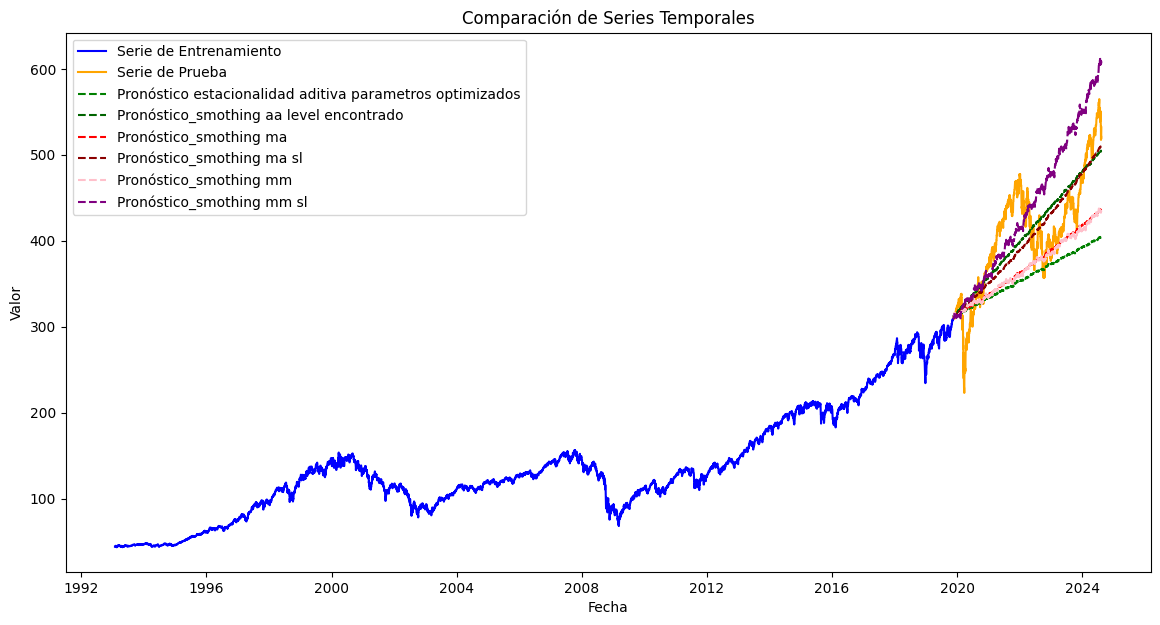

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(train1, label='Serie de Entrenamiento', color='blue')
plt.plot(test1, label='Serie de Prueba', color='orange')
plt.plot(forecast_exp_add, label='Pronóstico estacionalidad aditiva parametros optimizados', color='green', linestyle='--')
plt.plot(forecast_exp_add_sl, label='Pronóstico_smothing aa level encontrado', color='darkgreen', linestyle='--')
plt.plot(forecast_exp_ma, label='Pronóstico_smothing ma', color='red', linestyle='--')
plt.plot(forecast_exp_ma_sl, label='Pronóstico_smothing ma sl', color='darkred', linestyle='--')
plt.plot(forecast_exp_mm, label='Pronóstico_smothing mm', color='pink', linestyle='--')
plt.plot(forecast_exp_mm_sl, label='Pronóstico_smothing mm sl', color='purple', linestyle='--')

plt.title('Comparación de Series Temporales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

#Los mejores pronosticos encontrados son los Darkgreen y darkred pero en caso de nosotros querer ser conservadores podemos optar por un pronostico rosado o rojo,
#vamos a realizar los calculos de los resultados utilizando estos 4 y valiando los resultados de los mismos.




## Ahora vamos a realizar intentar realizar un pronostico utilizando metodoligia ARIMA de series de tiempo.


In [ ]:
#from sklearn.metrics import mean_squared_error
## Paso 4: Calcular el ECM (Error Cuadrático Medio)
## Asegúrate de que las series tengan la misma longitud
#if len(test1) == len(forecast_exp_add):
#    ecm = mean_squared_error(test1, forecast_exp_add)
#    print(f"Error Cuadrático Medio (ECM): {ecm:.4f}")
#else:
#    print("Las series de prueba y pronóstico deben tener la misma longitud para calcular el ECM.")

Error Cuadrático Medio (ECM): 1483.2496


In [30]:
# definimos la funcion de estacionariedad para hacer el calculo mas rapido.
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("La serie es estacionaria")
    else:
        print("La serie no es estacionaria")

print("Prueba de Dickey-Fuller para la serie original:")
test_stationarity(train1)

Prueba de Dickey-Fuller para la serie original:
ADF Statistic: 0.8091675011552388
p-value: 0.9917827167128594
Critical Values: {'1%': -3.4310187472666125, '5%': -2.8618355457824975, '10%': -2.5669273138932063}
La serie no es estacionaria



Prueba de Dickey-Fuller para la serie diferenciada (d=1):
ADF Statistic: -40.00256851921448
p-value: 0.0
Critical Values: {'1%': -3.4310187472666125, '5%': -2.8618355457824975, '10%': -2.5669273138932063}
La serie es estacionaria


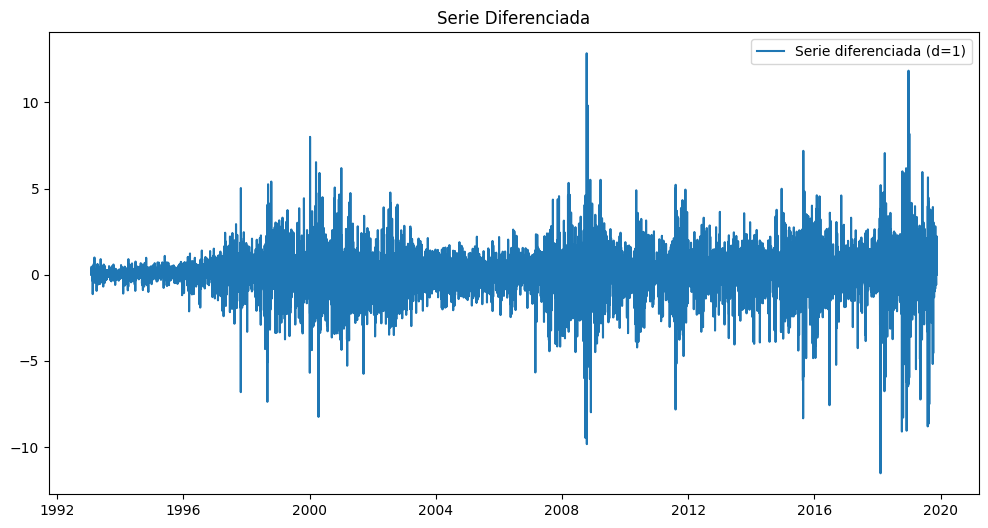

In [31]:
# Diferenciar la serie
d = 0
while True:
    d += 1
    differenced_series = train1.diff(d).dropna()
    print(f"\nPrueba de Dickey-Fuller para la serie diferenciada (d={d}):")
    test_stationarity(differenced_series)
    if adfuller(differenced_series)[1] <= 0.05:
        break

# Graficar la serie diferenciada
plt.figure(figsize=(12, 6))
plt.plot(differenced_series, label=f'Serie diferenciada (d={d})')
plt.title('Serie Diferenciada')
plt.legend()
plt.show()


In [33]:
differenced_series

,Close
Date,
1993-01-30,0.000000
1993-01-31,0.000000
1993-02-01,0.312500
1993-02-02,0.093750
1993-02-03,0.468750
...,...
2019-11-13,0.100006
2019-11-14,0.449982
2019-11-15,2.240021


Encontramos con la prueba de raiz unitaria de Dickey Fuller que el parametro d para el modelo arima tienenque ser 1 donde en la primera diferenciacion de la serie se encuetra una serie estacionaria.

Ahora vamos a calcular el parametro p y el parametro q de la misma, para ello vamos a evaluar los graficos de autocorrelacion y autocorrelacion parcial y detectar cuales son los parametros mas adecuados.


<ipython-input-36-fbf5073923b4>:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
<ipython-input-36-fbf5073923b4>:11: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(pacf_vals)), pacf_vals, use_line_collection=True)


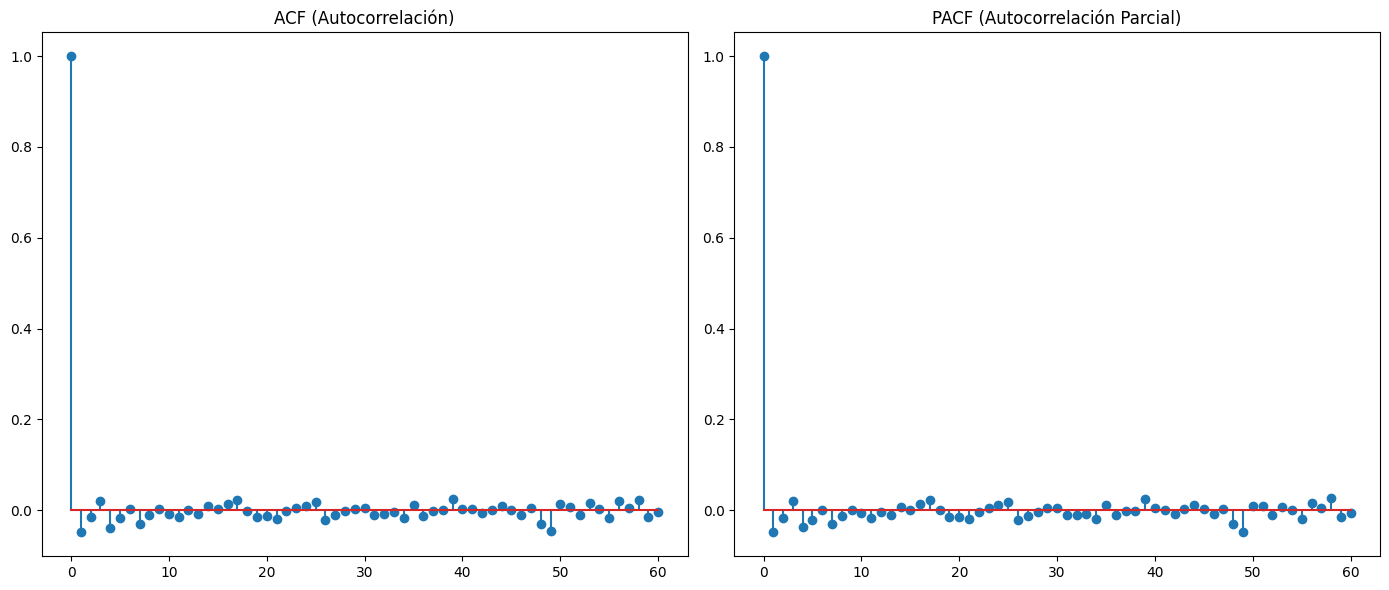

In [36]:
def plot_acf_pacf(series, lags=40):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    acf_vals = acf(series, nlags=lags)
    plt.stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
    plt.title('ACF (Autocorrelación)')

    plt.subplot(1, 2, 2)
    pacf_vals = pacf(series, nlags=lags)
    plt.stem(range(len(pacf_vals)), pacf_vals, use_line_collection=True)
    plt.title('PACF (Autocorrelación Parcial)')

    plt.tight_layout()
    plt.show()

# Graficar ACF y PACF para la serie diferenciada
plot_acf_pacf(differenced_series,60)

Siendo sinceros estos graficos no son de mi agrado para poder definir los paramtros p y q entehoria cuando cada uno de estos tienda a cero, ahi es cuando se deberia saber fijar los parametros, pero ellos caen de una a valores muy cercanos a cero donde se compleja la eleccion de estos parametros.

In [40]:
p = 2  # Parámetro AR (ejemplo, ajustar según el gráfico PACF)
q = 2  # Parámetro MA (ejemplo, ajustar según el gráfico ACF)

# Ajustar el modelo ARIMA
model = ARIMA(train1, order=(p, d, q))
model_fit = model.fit()

# Imprimir el resumen del modelo
print(model_fit.summary())

forecast = model_fit.forecast(steps=test1.shape[0])
forecast_index = pd.date_range(start=train1.index[-1] + pd.DateOffset(days=30), periods=test1.shape[0], freq='D')
forecast_series = pd.Series(forecast[0], index=forecast_index)

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(train1, label='Datos históricos')
plt.plot(forecast_series, label='Predicción', color='green')
plt.title('Predicción usando ARIMA')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 9789
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15999.342
Date:                Wed, 04 Sep 2024   AIC                          32008.684
Time:                        15:36:23   BIC                          32044.628
Sample:                    01-29-1993   HQIC                         32020.864
                         - 11-17-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8293      0.071    -11.736      0.000      -0.968      -0.691
ar.L2         -0.6210      0.060    -10.368      0.000      -0.738      -0.504
ma.L1          0.7838      0.073     10.755      0.0

#vamos a trabajar con 3 modelos para generar los resultaod de los mismos.
# estos modelos son los siguientes:

# 1. AA sl, ma sl y mm

De estos vamos realizar lo siguiente:

1. Estimacion del modelo con toda la data y los parametros previamente vistos.
2. Estimacion de valor esperado si se coloca el dinero en un CDT a 4 años con una tasa del 9% EA
3. Estimacion del aumento del etf con cada uno de los modelos seleccionados.
4. Grafico con las tres estimaciones.
5. Diferencias entre estos valores para saber cual de estos es el mejor.


In [17]:
#1. estimacion de los modelos con toda la data.
print(c_minimo['Parametro'])
print(cc_minimo['Parametro'])

model_exp_add_sl_t = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=365).fit(smoothing_level=c_minimo['Parametro'])
model_exp_ma_sl_t = ExponentialSmoothing(series, trend='mul', seasonal='add', seasonal_periods=365).fit(smoothing_level=cc_minimo['Parametro'])
model_exp_mm_t = ExponentialSmoothing(series, trend='mul', seasonal='mul', seasonal_periods=365).fit(optimized=True)



15    1.25
Name: Parametro, dtype: float64
10    1.0
Name: Parametro, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.

In [20]:
forecast_exp_add_sl_t = model_exp_add_sl_t.forecast(steps=1460) # 1460 son los dias correspondientes a 4 años que es lo presupuestado en el objetivo
forecast_exp_ma_sl_t = model_exp_ma_sl_t.forecast(steps=1460)
forecast_exp_mm_t = model_exp_mm_t.forecast(steps=1460)


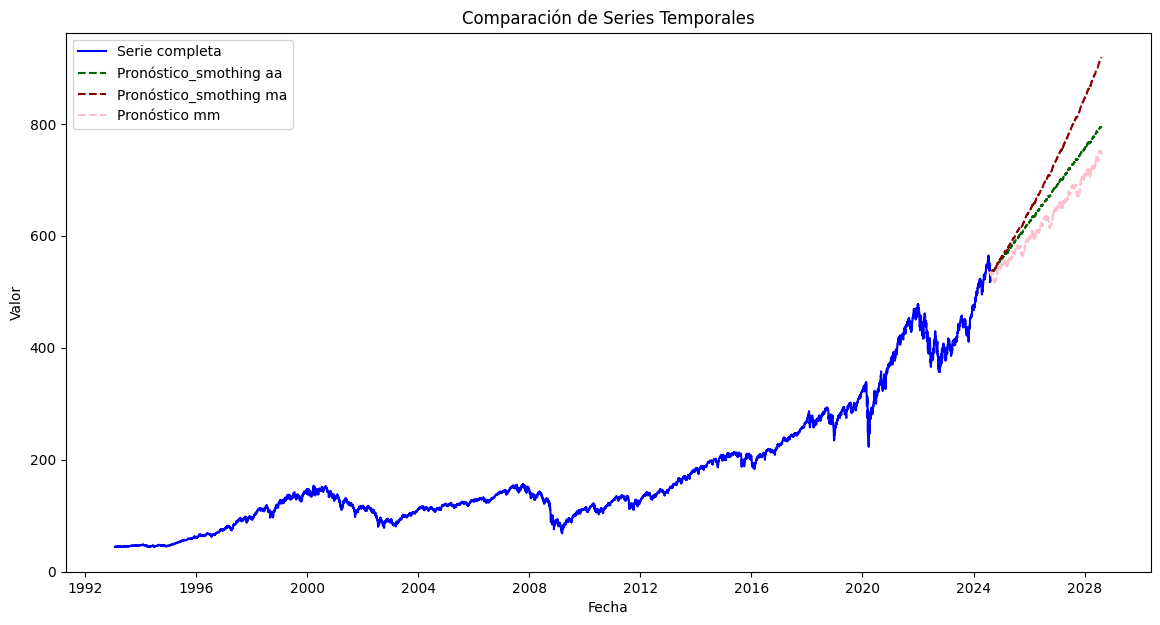

In [49]:
plt.figure(figsize=(14, 7))
plt.plot(series, label='Serie completa', color='blue')
plt.plot(forecast_exp_add_sl_t, label='Pronóstico_smothing aa', color='darkgreen', linestyle='--')
plt.plot(forecast_exp_ma_sl_t, label='Pronóstico_smothing ma', color='darkred', linestyle='--')
plt.plot(forecast_exp_mm_t, label='Pronóstico mm', color='pink', linestyle='--')
plt.title('Comparación de Series Temporales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [42]:
# vamos a ver el valor que tomaria el CDT si lo tendri a 4 años con una rentabilidad del 4% EA
print(f"ultimo valor del etf es de: {float(series[[-1]])}")
print(f"el ultimo valor que tomaria si colocara este en un CDT a 4 años con uns rentabilidad del 9% EA: {float(series[[-1]])*((1.09)**4)}")
print(f"Ganancia si se colocara este en un CDT seria de: {(float(series[[-1]])*((1.09)**4))-float(series[[-1]])}")
print(f"Ganancia en porcentaje vers su el valor inicial es: {((float(series[[-1]])*((1.09)**4))-float(series[[-1]]))/float(series[[-1]])}")

# la ganacia es aproximadamente un 41% del valor inicial.

ultimo valor del etf es de: 532.01001
el ultimo valor que tomaria si colocara este en un CDT a 4 años con uns rentabilidad del 9% EA: 750.9755464519163
Ganancia si se colocara este en un CDT seria de: 218.96553645191636
Ganancia en porcentaje versusu el valor inicial es: 0.41158161000000054


<ipython-input-42-34a078b928e1>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"ultimo valor del etf es de: {float(series[[-1]])}")
<ipython-input-42-34a078b928e1>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"ultimo valor del etf es de: {float(series[[-1]])}")
<ipython-input-42-34a078b928e1>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"el ultimo valor que tomaria si colocara este en un CDT a 4 años con uns rentabilidad del 9% EA: {float(series[[-1]])*((1.09)**4)}")
<ipython-input-42-34a0

In [51]:
# si tenemos en cuenta el pronostico mas conservador tiene una estimacion de:
print(f"si tenemos en cuenta el modelo mas conservador que es el de tendencia aditiva y estacionalidad aditiva, tenemos un valor del etf al final de los 4 años de: {int(forecast_exp_mm_t[[-1]])} el cual es muy cercano a la ganancia establecida previamente al CDT")
# ahora si tenemos en cuenta la informacion de los otros modelos se tendria lo siguiente:
print(f"si tomamos el modelo siguiente, el cual aditivo aditivo con SL establecido: {int(forecast_exp_add_sl_t[[-1]])}")
# este tiene una ganacia de:
print(f"Ganancia en porcentaje aa sl versus el valor inicial es: {((int(forecast_exp_add_sl_t[[-1]]))-float(series[[-1]]))/float(series[[-1]])}")
### con el ultimo modelo se tien un valor de:
print(f"si tomamos el modelo siguiente, el cual aditivo multiplicativo con SL establecido: {int(forecast_exp_ma_sl_t[[-1]])}")
# este tiene una ganacia de:
print(f"Ganancia en porcentaje aa sl versus el valor inicial es: {((int(forecast_exp_ma_sl_t[[-1]]))-float(series[[-1]]))/float(series[[-1]])}")






si tenemos en cuenta el modelo mas conservador que es el de tendencia aditiva y estacionalidad aditiva, tenemos un valor del etf al final de los 4 años de: 750 el cual es muy cercano a la ganancia establecida previamente al CDT
si tomamos el modelo siguiente, el cual aditivo aditivo con SL establecido: 795
Ganancia en porcentaje aa sl versus el valor inicial es: 0.49433278520454915
si tomamos el modelo siguiente, el cual aditivo multiplicativo con SL establecido: 919
Ganancia en porcentaje aa sl versus el valor inicial es: 0.7274111064188437


<ipython-input-51-3568234a34a0>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"si tenemos en cuenta el modelo mas conservador que es el de tendencia aditiva y estacionalidad aditiva, tenemos un valor del etf al final de los 4 años de: {int(forecast_exp_mm_t[[-1]])} el cual es muy cercano a la ganancia establecida previamente al CDT")
<ipython-input-51-3568234a34a0>:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"si tenemos en cuenta el modelo mas conservador que es el de tendencia aditiva y estacionalidad aditiva, tenemos un valor del etf al final de los 4 años de: {int(forecast_exp_mm_t[[-1]])} el cual es muy cercano a la ganancia establecida previamente al CDT")
<ipython-input-51-3568234

#Conclusiones

1. Con un estimador tenemos la misma ganacia que colocando el dinero en un CDT a esa tasa en especifico
2. Si tenemos en cuenta el siguiente modelo se tendria un aumento de 41% al 49% es decir un 8% mas que el que se ubiera optenido por el CDT
3. pero si nos vamos pr la estimacion mas agresiva se tiene un incremento del 72% un 31% adicional al que dejaria el CDT.

Como coclusion y con la informacion que se tiene hasta el momento sin tener en cuenta los costos que se generados por impuestos (4X1000) entre otros y por los costos generados por operar con un broker y ello.

Yo personalmente dejaria mi dinero en el ETF SPY, ya que este tiene un rendimiento que por conservador que sea lo mas probable es que llegue al mismo valor del CDT, pero tambien puedo establecer parametros de venta en el 4to año ya que lo mas probable es que este valor tome valores por encima o por debajo, lo que puedo hacer es fijar un valor de venta por encima segun las variaciones presentadas en los ultimo años y asi fijar un valor donde yo tenga la seguridad que el ETF tomara este valor para vnederlo a buen precio.
  